In [1]:
import time
import numpy as np
import datetime
import pandas as pd
from datetime import date
from datetime import datetime
from scipy.optimize import minimize
np.seterr(all="ignore")
import matplotlib.pyplot as plt

#### Hagan IV and Error function, and scipy_minimize, and constraints

In [2]:
#hagan iv approximation
def iv_hagan(initial_price, initial_vol, volvol,T,K, p):
    z=(volvol/initial_vol)*np.log(initial_price/K)

    a=np.sqrt(1-2*p*z+z*z)+z-p
    
    if(z==0):
        div=1
    else:
        xz= np.log(a/(1-p))
        div=z/xz
    
    b=(0.25*volvol*p*initial_vol)+((2-3*p*p)/24)*volvol*volvol
    iv=initial_vol*(1+b*T)*(div)
    
    return iv

#compute the squared error between observed ivs and hagan approximation
def squared_error(T, Strikes, IVs, initial_price, initial_vol, volvol, p):
    error=0
    
    for i in range(len(Strikes)):
        K=Strikes[i]
        iv=IVs[i]
        iv_obs=iv_hagan(initial_price, initial_vol, volvol, T, K, p)
        
        error=error+((iv-iv_obs)**2)
    
    return error

#same function adapted to fit scipy_minimize given (initial_vol, volvol, p) as parameters
def squared_error_minimize(params, T, Strikes, IVs, initial_price):
    error=0
    initial_vol, volvol, p = params
    
    for i in range(len(Strikes)):
        K=Strikes[i]
        
        iv=IVs[i]
        iv_obs=iv_hagan(initial_price, initial_vol, volvol, T, K, p)
        
        error=error+((iv-iv_obs)**2)
    
    
    return error


#constraints
def initial_vol_constraint(args):
    return args[0]

def volvol_constraint(args):
    return args[1]

def p_constraint1(args):
    return args[2]+1

def p_constraint2(args):
    return 1- args[2]

con1 = {'type': 'ineq', 'fun': initial_vol_constraint} #vol>0
con2 = {'type': 'ineq', 'fun': volvol_constraint} #volvol>0
con3 = {'type': 'ineq', 'fun': p_constraint1} #p+1>0
con4 = {'type': 'ineq', 'fun': p_constraint2} #1-p>0
cons = (con1, con2, con3, con4)

#### Reading data

In [3]:
# read the sheet
observed_data = pd.read_excel('ExcelPandas.xlsx')
current_date = datetime(2019, 4, 11)

#get the data
Strikes=np.array(observed_data["Strikes"])
maturities=observed_data.columns.delete(0)

#observed atm iv for each maturity
initial_prices=[3424.623364, 3424.922072, 3425.158183, 3425.380282, 3425.657945, 3426.339971, 3426.941883, 3427.506049, 3429.085029, 3431.578705, 3435.536865, 3447.689998, 3381.668242,3300.929292, 3230.274156, 3169.113236, 3117.129183, 3071.46125]
atm=[0.115735591,0.128754521,0.133229439,0.13664925,0.138609508,0.14333159,0.145744268,0.149925638,0.15618917,0.162945787,0.165823084,0.175587126,0.185133536,0.194641185,0.204257386,0.214141582,0.224589045,0.230527406]

#### Compute the calibration given a date

In [16]:
#store the initial prices get through the atm
#initial_prices=[0]*len(maturities)

def calibration(expiration_date, plot):
    #get maturity time in yearw
    days=(expiration_date-current_date).days
    T=days/365
    
    #ivs observed at that maturity
    IVs=np.array(observed_data[expiration_date])

    """
    #get initial price using atm ivs
    #get the atm observed for that maturity
    column_index = maturities.get_loc(expiration_date)
    atm_obs=atm[column_index]
 
    #initial_price=iv closest to the atm iv
    min_dif=1000
    i=0
    previous_iv=10
    for iv in IVs:
        dif=abs(atm_obs-iv)
        if dif<min_dif and iv<previous_iv:
            min_dif=dif
            initial_price=Strikes[i]

        i=i+1
        previous_iv=iv
    
    #store it for later 
    initial_prices[column_index]=initial_price
    """
    column_index = maturities.get_loc(expiration_date)
    initial_price=initial_prices[column_index]
    
    #calibrate the parameters
    first_guess =[0.15, 0.5, 0]#initial vol/alpha, volvol/v, p
    res = minimize(squared_error_minimize, first_guess, args=(T, Strikes, IVs, initial_price), constraints=cons)
    
    if plot:
        log_moneyness=np.log(initial_price/Strikes)
        
        #plot the observed ivs
        plt.plot(log_moneyness,IVs, color="red", label="observed iv",linewidth=5)
        
        #predicted ivs
        ivs_predicted=[0]*len(Strikes)
        initial_vol, volvol,p=res.x
        for i in range(len(Strikes)):
            ivs_predicted[i]=iv_hagan(initial_price, initial_vol, volvol,T,Strikes[i], p)
        
        plt.plot(log_moneyness,ivs_predicted, color="blue", label="calibrated iv")
        plt.legend()
        #plt.title("17/05/2019 Calibration")
        plt.xlabel("Log-Moneyness")
        plt.ylabel("IV")
        plt.savefig("1st cal")
        plt.show()
    print(res)
    return res.x #initial vol, volvol, p  

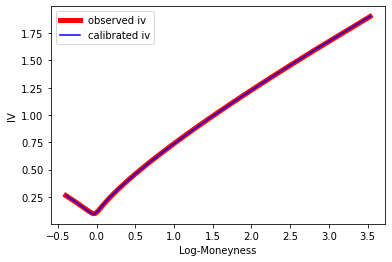

     fun: 0.00017086121551146554
     jac: array([-0.00523007, -0.00041467, -0.0011391 ])
 message: 'Optimization terminated successfully'
    nfev: 52
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([ 0.1058529 ,  2.45386866, -0.6003328 ])


array([ 0.1058529 ,  2.45386866, -0.6003328 ])

In [17]:
day=datetime(2019,5,17)
calibration(day,True)

### Going through all the Maturities

In [9]:
data_cleaned=observed_data.drop(columns=["Strikes"], inplace=False)

2019-05-17 00:00:00


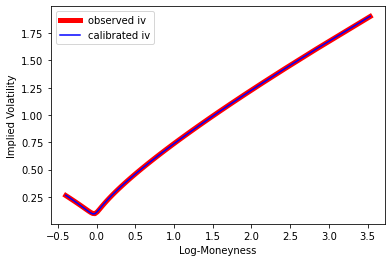

     fun: 0.00017086121551146554
     jac: array([-0.00523007, -0.00041467, -0.0011391 ])
 message: 'Optimization terminated successfully'
    nfev: 52
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([ 0.1058529 ,  2.45386866, -0.6003328 ])
[ 0.1058529   2.45386866 -0.6003328 ]


2019-06-21 00:00:00


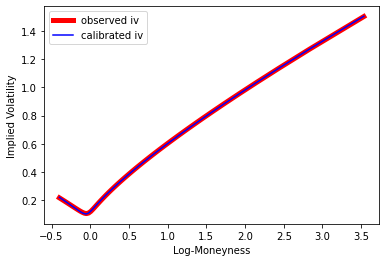

     fun: 0.00015059420845409488
     jac: array([-0.00107315, -0.00017661,  0.00069458])
 message: 'Optimization terminated successfully'
    nfev: 43
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([ 0.11682635,  1.76426714, -0.57785282])
[ 0.11682635  1.76426714 -0.57785282]


2019-07-19 00:00:00


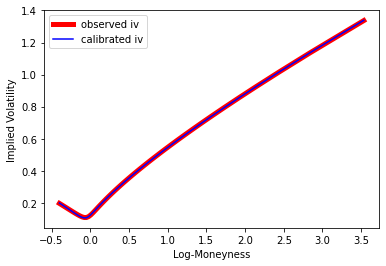

     fun: 9.391594053113496e-05
     jac: array([-0.00079732,  0.00032267, -0.00117476])
 message: 'Optimization terminated successfully'
    nfev: 40
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([ 0.1220507 ,  1.49527538, -0.58095283])
[ 0.1220507   1.49527538 -0.58095283]


2019-08-16 00:00:00


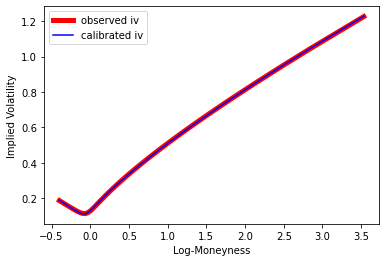

     fun: 6.751611224493665e-05
     jac: array([-1.68705245e-03, -2.77883310e-05, -1.76496662e-04])
 message: 'Optimization terminated successfully'
    nfev: 43
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([ 0.12581885,  1.3218997 , -0.57962009])
[ 0.12581885  1.3218997  -0.57962009]


2019-09-20 00:00:00


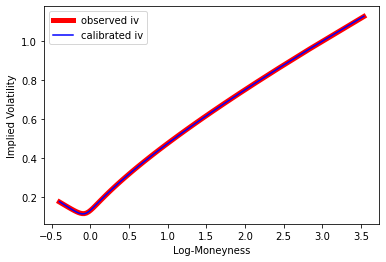

     fun: 4.400185423884176e-05
     jac: array([ 0.00010518,  0.00024979, -0.00012085])
 message: 'Optimization terminated successfully'
    nfev: 43
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([ 0.12859412,  1.17073816, -0.58117542])
[ 0.12859412  1.17073816 -0.58117542]


2019-12-20 00:00:00


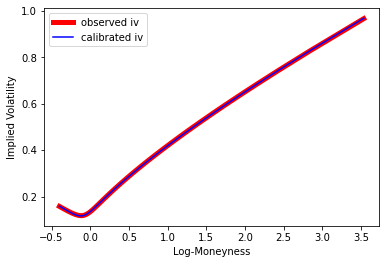

     fun: 2.474148570198428e-05
     jac: array([ 0.00293811,  0.00165313, -0.00021104])
 message: 'Optimization terminated successfully'
    nfev: 39
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([ 0.13363674,  0.94034536, -0.57377686])
[ 0.13363674  0.94034536 -0.57377686]


2020-03-20 00:00:00


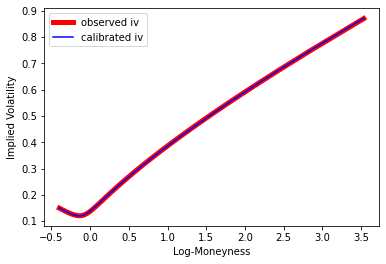

     fun: 1.5791514855700277e-05
     jac: array([ 8.04042319e-04,  1.72051122e-04, -7.56482546e-05])
 message: 'Optimization terminated successfully'
    nfev: 43
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([ 0.13648945,  0.80766773, -0.5673118 ])
[ 0.13648945  0.80766773 -0.5673118 ]


2020-06-19 00:00:00


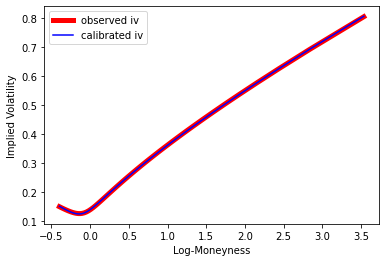

     fun: 2.9175053790429685e-05
     jac: array([ 5.75747144e-04,  1.09194983e-04, -6.72954759e-05])
 message: 'Optimization terminated successfully'
    nfev: 43
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([ 0.13624626,  0.72853904, -0.51787865])
[ 0.13624626  0.72853904 -0.51787865]


2020-12-18 00:00:00


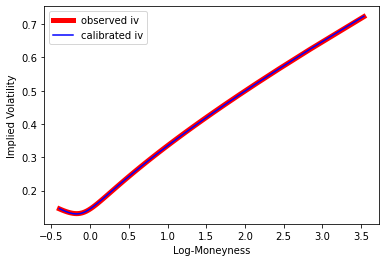

     fun: 1.539227649336205e-05
     jac: array([ 0.00284392,  0.00123747, -0.00046746])
 message: 'Optimization terminated successfully'
    nfev: 39
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([ 0.14323117,  0.61254754, -0.50899328])
[ 0.14323117  0.61254754 -0.50899328]


2021-06-18 00:00:00


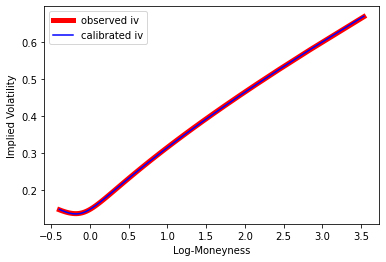

     fun: 1.6325885116928695e-05
     jac: array([-0.00023214, -0.00090163,  0.00031969])
 message: 'Optimization terminated successfully'
    nfev: 35
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([ 0.14691455,  0.54401812, -0.45983322])
[ 0.14691455  0.54401812 -0.45983322]


2021-12-17 00:00:00


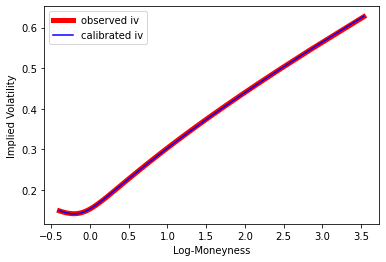

     fun: 1.052988367965136e-05
     jac: array([-0.00055775, -0.00105695,  0.00031382])
 message: 'Optimization terminated successfully'
    nfev: 35
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([ 0.15051431,  0.49096356, -0.45031512])
[ 0.15051431  0.49096356 -0.45031512]


2022-12-16 00:00:00


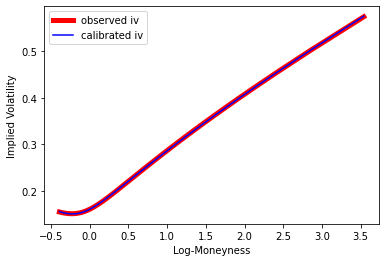

     fun: 7.5258652121817265e-06
     jac: array([-0.00226731, -0.00058872,  0.00010989])
 message: 'Optimization terminated successfully'
    nfev: 31
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([ 0.15835754,  0.42246708, -0.39866752])
[ 0.15835754  0.42246708 -0.39866752]


2023-12-15 00:00:00


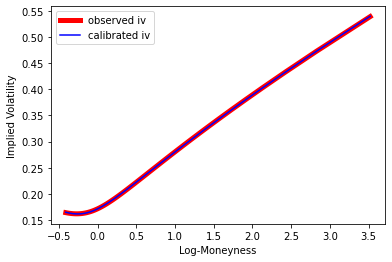

     fun: 4.30328249133699e-06
     jac: array([-0.00074438, -0.00093702,  0.00023226])
 message: 'Optimization terminated successfully'
    nfev: 35
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([ 0.16894254,  0.37383938, -0.38148175])
[ 0.16894254  0.37383938 -0.38148175]


2024-12-20 00:00:00


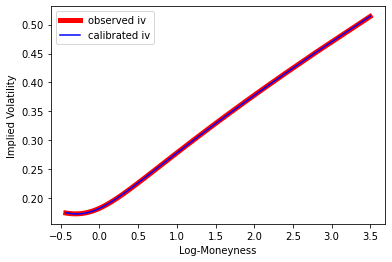

     fun: 2.54737178532818e-06
     jac: array([-0.01084586, -0.00301607,  0.0001782 ])
 message: 'Optimization terminated successfully'
    nfev: 35
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([ 0.17977747,  0.33765812, -0.36879677])
[ 0.17977747  0.33765812 -0.36879677]


2025-12-19 00:00:00


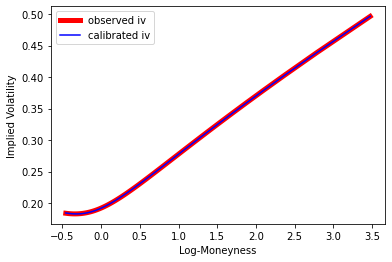

     fun: 1.8708576936916768e-06
     jac: array([-0.00998104, -0.00285337,  0.00026261])
 message: 'Optimization terminated successfully'
    nfev: 35
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([ 0.1902441 ,  0.31072018, -0.3505672 ])
[ 0.1902441   0.31072018 -0.3505672 ]


2026-12-18 00:00:00


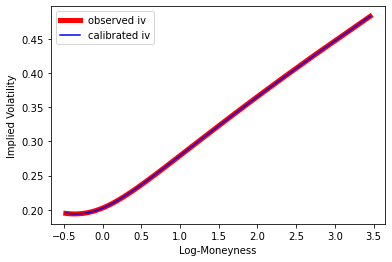

     fun: 1.6081302523415217e-06
     jac: array([-3.18715372e-04, -8.35367642e-05,  2.00640844e-05])
 message: 'Optimization terminated successfully'
    nfev: 38
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([ 0.20067192,  0.28929225, -0.32934409])
[ 0.20067192  0.28929225 -0.32934409]


2027-12-17 00:00:00


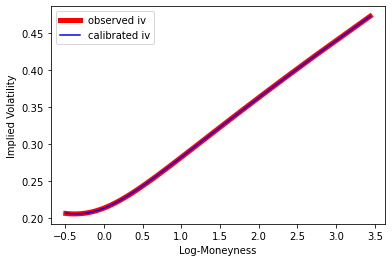

     fun: 1.5556663308288048e-06
     jac: array([-4.77742904e-04, -7.55684332e-05,  2.40659974e-05])
 message: 'Optimization terminated successfully'
    nfev: 38
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([ 0.21141906,  0.27166574, -0.30630215])
[ 0.21141906  0.27166574 -0.30630215]


2028-12-15 00:00:00


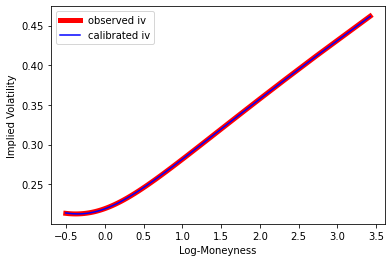

     fun: 1.8149541854385265e-06
     jac: array([-3.62160393e-04, -5.61513459e-05,  4.52700771e-05])
 message: 'Optimization terminated successfully'
    nfev: 38
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([ 0.2172001 ,  0.25706342, -0.27856077])
[ 0.2172001   0.25706342 -0.27856077]




In [10]:
params_per_maturity=[0]*len(maturities)
i=0
for maturity in data_cleaned:
    #calibrate each maturity
    print(maturity)
    predicted_params=calibration(maturity,True)
    params_per_maturity[i]=predicted_params
    i=i+1
    print(predicted_params)
    print("\n")

### Plot volatility surfaces

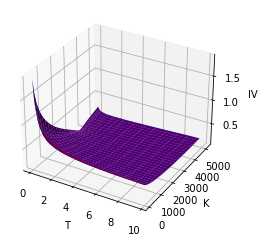

In [20]:
a=maturities.values.tolist()
a=np.array(a)

b=(a-current_date)
for i in range(len(b)):
    b[i]=b[i].days
b=b/365
T=np.array(b).astype(float)
Strikes=np.array(Strikes).astype(float)

Tp,K=np.meshgrid(T,Strikes)
iv_plot=observed_data.copy()
iv_plot=(iv_plot.iloc[:, 1:]).to_numpy()

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# Plot the surface.
surf = ax.plot_surface(Tp, K, iv_plot, color="red", label="obs",alpha=0.4) #color="r"

i=0
iv_predicted=iv_plot.copy()
for maturity in T:
    #each maturity has a different params and initial price
    initial_vol,volvol,p = params_per_maturity[i]
    j=0
    for strike in Strikes:
        iv_predicted[j][i]=iv_hagan(initial_prices[i], initial_vol, volvol,maturity,strike, p)
        j=j+1
    i=i+1

# Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.5, aspect=5, pad=0.12)
surf1 = ax.plot_surface(Tp, K, iv_predicted, color="blue",label="pred",alpha=1) #color="r"

#Axis and titles
ax.set_xlabel('T')
ax.set_ylabel('K')
ax.set_zlabel('IV')


plt.savefig("FinalCalibration")
plt.show()

### Images for introduction

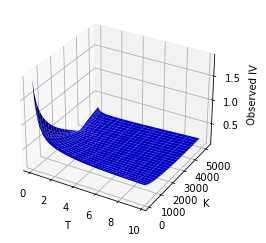

In [15]:
a=maturities.values.tolist()
a=np.array(a)
b=(a-current_date)
for i in range(len(b)):
    b[i]=b[i].days
b=b/365
T=np.array(b).astype(float)

Strikes=np.array(Strikes).astype(float)

Tp,K=np.meshgrid(T,Strikes)
iv_plot=observed_data.copy()
iv_plot=(iv_plot.iloc[:, 1:]).to_numpy()

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# Plot the surface.
surf = ax.plot_surface(Tp, K, iv_plot, color="blue", label="obs") #color="r"

#Axis and titles
ax.set_xlabel('T')
ax.set_ylabel('K')
ax.set_zlabel('Observed IV')

plt.savefig("Observed IV")
plt.show()

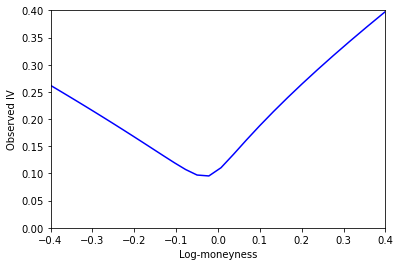

In [14]:
expiration_date=datetime(2019,5,17)

#get maturity time in yearw
days=(expiration_date-current_date).days
T=days/365
    
#ivs observed at that maturity
IVs=np.array(observed_data[expiration_date])

column_index = maturities.get_loc(expiration_date)
initial_price=initial_prices[column_index] 

log_moneyness=np.log(initial_price/Strikes)
        
 #plot the observed ivs
plt.plot(log_moneyness,IVs, color="blue")
        

plt.xlabel("Log-moneyness")
plt.ylabel("Observed IV")
plt.xlim(-0.4,0.4) 
plt.ylim(0,0.4)
plt.savefig("Observed_iv_for_strike")
plt.show()
